## Coursera Capstone Project

# Chicago Hardship Index and Venues

Chicago is a multicultural city and provides many opportunities to its inhabitants. However not all communities present in the city have the same distribution and opportunities are different for people living among different areas.
The Chicago goverment have deployed a **hardship index** which is multidimensional measure of community socioeconomic conditions, the higher the index the worse economical and social conditions are.

Using the information provided by Foursquare we want to asses which kind of venues are present in communities with different hardship indexes. If there are any differences, we can use this information to propose building specific tipes of venues to improve the communities conditions.

Also we aim to verify if the venue consistency in a neighborhood will be a good predictor for the hardship index, this will be useful to quickly assess the conditions of different locations without censing the population directly.

---

#### Importing libraries

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import folium

from geopy.geocoders import ArcGIS

import requests

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from scipy.stats import chisquare

/home/emmanuel/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# The Data

We are going to use the **Chicago Hardship Index** based on Census Data from 2008 to 2012, from this dataset we are going to use only two columns the Community Area Name and the Hardship Index.

Along this dataset we are going to use Foursquare database to check what venues are more popular in each of the Community Areas, we are going to use the Category column from this dataset. 

Lastly to plot our findings in the map we are going to use the shape files corresponding to the boundaries of the Community Areas provided by the Chicago City government. Available at: https://data.cityofchicago.org/Facilities-Geographic-Boundaries/Boundaries-Community-Areas-current-/cauq-8yn6

The **Chicago Hardship Index** dataset is publicly available at https://data.cityofchicago.org/Health-Human-Services/hardship-index/792q-4jtu and it consists in 78 rows by 7 columns, each row corresponding to one community plus one extra row for the Chicago city average.
The columns are:

    - Hardship Index
    - Community Area Name
    - Percent of Households Below Poverty
    - Percent of people aged 25+ without a Highschool Diploma
    - Percent of people aged 16+ unemployed
    - Percent of people aged below 18 or over 64
    - Per Capita Income
    
For the scope of this exercise we're are only going to use the 'Hardship Index' column and the 'Community Area Name'




In [2]:
#Get the geojson data for the communities boundaries
geojson = r'Data/Boundaries - Community Areas (current).geojson'

#Get the Chicago Hardship Index
chicago_h_i = pd.read_csv('Data/hardship_index.csv')

### Preprocessing the Chicago Hardship Index data


In [3]:
# Let's take a peek of the Chicago Hardship Index dataframe
chicago_h_i.head()

HARDSHIP INDEX COMMUNITY AREA NAME  PERCENT HOUSEHOLDS BELOW POVERTY  \
0            39.0         Rogers Park                              23.6   
1            46.0          West Ridge                              17.2   
2            20.0              Uptown                              24.0   
3            17.0      Lincoln Square                              10.9   
4             6.0        North Center                               7.5   

   PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA  PERCENT AGED 16+ UNEMPLOYED  \
0                                          18.2                          8.7   
1                                          20.8                          8.8   
2                                          11.8                          8.9   
3                                          13.4                          8.2   
4                                           4.5                          5.2   

   PERCENT AGED UNDER 18 OR OVER 64  PER CAPITA INCOME   
0                              27.5               23939  
1                              38.5               23040  
2                              22.2               35787  
3                              25.5               37524  
4                              26.2               57123

#### If we look at the CHICAGO row in the Community Area Name we'll notice it has no Hardship Index assigned so lets drop it

In [4]:
chicago_h_i[chicago_h_i['COMMUNITY AREA NAME'] == 'CHICAGO']['HARDSHIP INDEX']

77   NaN
Name: HARDSHIP INDEX, dtype: float64

In [5]:
chicago_h_i.dropna(inplace=True)

In [6]:
# First let's keep only the rows we're going to use
chicago_h_i = chicago_h_i.loc[:,['HARDSHIP INDEX', 'COMMUNITY AREA NAME']]

#The community area names in the geojson file are in uppercase, so let's uppercase the names in our dataset
chicago_h_i['COMMUNITY AREA NAME'] = chicago_h_i['COMMUNITY AREA NAME'].str.upper()

#And our dataset looks like this
chicago_h_i

HARDSHIP INDEX COMMUNITY AREA NAME
0             39.0         ROGERS PARK
1             46.0          WEST RIDGE
2             20.0              UPTOWN
3             17.0      LINCOLN SQUARE
4              6.0        NORTH CENTER
..             ...                 ...
72            48.0   WASHINGTON HEIGHT
73            16.0     MOUNT GREENWOOD
74            30.0         MORGAN PARK
75            24.0              O'HARE
76            19.0           EDGEWATER

[77 rows x 2 columns]

#### Before proceding let's fix some mismatching information between the community names in the dataframe and in the geojson file

In [7]:
#The locations causing trouble are O'Hare, Montclaire and Washington Height so let's change them

chicago_h_i.loc[75,'COMMUNITY AREA NAME'] = 'OHARE'
chicago_h_i.loc[72,'COMMUNITY AREA NAME'] = 'WASHINGTON HEIGHTS'
chicago_h_i.loc[17,'COMMUNITY AREA NAME'] = 'MONTCLARE'

#### Let's draw our first Chicago Map

In [8]:
# Adding the coordinates of the city
latitude = 41.881832
longitude = -87.623177

# Creating a Chicago map
chicago_map = folium.Map(location=[latitude, longitude], zoom_start=10)

# And now let's make this map tell us where are the communities and what is their Hardship Index
folium.Choropleth(geo_data = geojson,
                name = 'choropleth',
                data = chicago_h_i,
                columns= ['COMMUNITY AREA NAME','HARDSHIP INDEX'],
                key_on= 'feature.properties.community',
                fill_color='YlOrRd',
                fill_opacity=0.5,
                line_opacity=0.2,
                legend_name='Hardship Index').add_to(chicago_map)

#Display the map
chicago_map

## Nice!

That map is looking good however we can't tell what are the districts names so let us add a few markers

In order to add the markers we need to make use of the geopy.geocoders to get the coordinates of each district. I have used the ArcGis geocoder because is simple to use, it requires no user name and/or key

### Note:

#### I have created a CSV file with the coordinates of each community to avoid requesting for the data a lot of times, here I show you the code I have used to get it:
    
``` python
user_agent = "chicago_com" # Let's define a user agent name

geolocator = ArcGIS(user_agent=user_agent) # Instantiate an ArcGIS geolocator

def get_ll(community):   # Define a function that will retrieve the coordinates of a given community
    
    address = f'{community}, Chicago, Illinois'   # Concatenate the query string
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude, longitude

# Define a function that returns the latitude
def lat(location):
    return location[0]

# Define a function that returns the longitude
def long(location):
    return location[1]


#Create a new column that will receive the location data
chicago_bin['location'] = chicago_bin['COMMUNITY AREA NAME'].apply(lambda x: get_ll(x))

#Create a new column that will receive the latitude and longitude data
chicago_bin['LATITUDE'] = chicago_bin['location'].apply(lambda x: lat(x))
chicago_bin['LONGITUDE'] = chicago_bin['location'].apply(lambda x: long(x))

# Drop the location column as we now have LATITUDE and LONGITUDE columns
chicago_bin.drop('location', inplace=True, axis=1)

```

In [9]:
# Now load the communities coordinates from the CSV file

coordinates = pd.read_csv("Data/coordinates.csv")
chicago_h_i = pd.concat([chicago_h_i,coordinates[['LATITUDE','LONGITUDE']]],axis=1)

chicago_h_i

HARDSHIP INDEX COMMUNITY AREA NAME  LATITUDE  LONGITUDE
0             39.0         ROGERS PARK  42.00897  -87.66619
1             46.0          WEST RIDGE  41.99948  -87.69266
2             20.0              UPTOWN  41.96538  -87.66936
3             17.0      LINCOLN SQUARE  41.97583  -87.68914
4              6.0        NORTH CENTER  41.95411  -87.68142
..             ...                 ...       ...        ...
72            48.0  WASHINGTON HEIGHTS  41.71584  -87.64884
73            16.0     MOUNT GREENWOOD  41.69145  -87.70830
74            30.0         MORGAN PARK  41.69039  -87.66599
75            24.0               OHARE  41.97959  -87.90446
76            19.0           EDGEWATER  41.98571  -87.66346

[77 rows x 4 columns]

In [10]:
#Lets add the markers

for lat, lng, label in zip(chicago_h_i['LATITUDE'],chicago_h_i['LONGITUDE'], chicago_h_i['COMMUNITY AREA NAME']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=4,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.6,
        parse_html=False).add_to(chicago_map) 

### Show the new map!

If you click a marker you'll get the community name

In [11]:
chicago_map

## Lets analyze our data

### Wrangling data again!

#### We're going to convert the Hardship Index into a categorical variable, in this case we will use 6 bins

In [12]:
chicago_bin = chicago_h_i.copy(deep=True)

bin_labels = ['Very Low','Low','Medium Low','Medium high','High','Very high']

chicago_bin['HARDSHIP INDEX'] = pd.cut(chicago_bin['HARDSHIP INDEX'],bins=6,labels=bin_labels)

chicago_bin.head()

HARDSHIP INDEX COMMUNITY AREA NAME  LATITUDE  LONGITUDE
0     Medium Low         ROGERS PARK  42.00897  -87.66619
1     Medium Low          WEST RIDGE  41.99948  -87.69266
2            Low              UPTOWN  41.96538  -87.66936
3       Very Low      LINCOLN SQUARE  41.97583  -87.68914
4       Very Low        NORTH CENTER  41.95411  -87.68142

### Let's get the Foursquare data for the venues in a 500m radius aroun each community

#### I've already saved this data in another CSV file ('chicago_venues.csv'). The data was obtained with the following code:

```python
import os

CLIENT_ID = os.getenv('CLIENT_ID')
CLIENT_SECRET = os.getenv('CLIENT_SECRET')
VERSION = '20180604'


def getNearbyVenues(names, latitudes, longitudes, radius=500):
    LIMIT = 50
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Community', 
                  'Community Latitude', 
                  'Community Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)


    #Let's call our function


chicago_venues = getNearbyVenues(names=chicago_bin['COMMUNITY AREA NAME'],
                                   latitudes=chicago_bin['LATITUDE'],
                                   longitudes=chicago_bin['LONGITUDE']
                                  )
```

#### Load the venue data from the CSV file

In [13]:
chicago_venues = pd.read_csv('Data/chicago_venues.csv', index_col=0)
chicago_venues.head()

Community  Community Latitude  Community Longitude  \
0  Rogers Park            42.00897            -87.66619   
1  Rogers Park            42.00897            -87.66619   
2  Rogers Park            42.00897            -87.66619   
3  Rogers Park            42.00897            -87.66619   
4  Rogers Park            42.00897            -87.66619   

                    Venue  Venue Latitude  Venue Longitude Venue Category  
0      Morse Fresh Market       42.008087       -87.667041  Grocery Store  
1      Rogers Park Social       42.007360       -87.666265            Bar  
2          The Common Cup       42.007797       -87.667901    Coffee Shop  
3        Lifeline Theatre       42.007372       -87.666284        Theater  
4  Rogers Park Provisions       42.007528       -87.666193      Gift Shop

#### One-hot encode the data

In [14]:
# one hot encoding
chicago_onehot = pd.get_dummies(chicago_venues[['Venue Category']], prefix="", prefix_sep="")

# add community column back to dataframe
chicago_onehot['COMMUNITY'] = chicago_venues['Community'] 

# move community column to the first column
fixed_columns = [chicago_onehot.columns[-1]] + list(chicago_onehot.columns[:-1])
chicago_onehot = chicago_onehot[fixed_columns]

chicago_onehot.head()

COMMUNITY  ATM  Accessories Store  Afghan Restaurant  African Restaurant  \
0  Rogers Park    0                  0                  0                   0   
1  Rogers Park    0                  0                  0                   0   
2  Rogers Park    0                  0                  0                   0   
3  Rogers Park    0                  0                  0                   0   
4  Rogers Park    0                  0                  0                   0   

   Airport  Airport Lounge  Airport Service  American Restaurant  \
0        0               0                0                    0   
1        0               0                0                    0   
2        0               0                0                    0   
3        0               0                0                    0   
4        0               0                0                    0   

   Amphitheater  ...  Video Game Store  Video Store  Vietnamese Restaurant  \
0             0  ...                 0            0                      0   
1             0  ...                 0            0                      0   
2             0  ...                 0            0                      0   
3             0  ...                 0            0                      0   
4             0  ...                 0            0                      0   

   Weight Loss Center  Whisky Bar  Wine Bar  Wine Shop  Wings Joint  \
0                   0           0         0          0            0   
1                   0           0         0          0            0   
2                   0           0         0          0            0   
3                   0           0         0          0            0   
4                   0           0         0          0            0   

   Women's Store  Yoga Studio  
0              0            0  
1              0            0  
2              0            0  
3              0            0  
4              0            0  

[5 rows x 260 columns]

#### And group the data by community

In [15]:
chicago_grouped = chicago_onehot.groupby('COMMUNITY').sum().reset_index()
chicago_grouped.head()

COMMUNITY  ATM  Accessories Store  Afghan Restaurant  \
0     Albany Park    0                  0                  0   
1  Archer Heights    0                  0                  0   
2   Armour Square    0                  0                  0   
3         Ashburn    0                  0                  0   
4  Auburn Gresham    0                  0                  0   

   African Restaurant  Airport  Airport Lounge  Airport Service  \
0                   0        0               0                0   
1                   0        0               0                0   
2                   0        0               0                0   
3                   0        0               0                0   
4                   0        0               0                0   

   American Restaurant  Amphitheater  ...  Video Game Store  Video Store  \
0                    0             0  ...                 0            0   
1                    0             0  ...                 0            1   
2                    2             0  ...                 0            0   
3                    0             0  ...                 0            0   
4                    0             0  ...                 0            0   

   Vietnamese Restaurant  Weight Loss Center  Whisky Bar  Wine Bar  Wine Shop  \
0                      0                   0           0         0          0   
1                      0                   0           0         0          0   
2                      0                   0           0         0          0   
3                      0                   0           0         0          0   
4                      0                   0           0         0          0   

   Wings Joint  Women's Store  Yoga Studio  
0            0              0            0  
1            1              0            0  
2            0              0            0  
3            0              0            0  
4            0              0            0  

[5 rows x 260 columns]

### Let's see what are the top 3 venues in each community

In [16]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [17]:
num_top_venues = 3

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['COMMUNITY']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
community_venues_sorted = pd.DataFrame(columns=columns)
community_venues_sorted['COMMUNITY'] = chicago_grouped['COMMUNITY']

for ind in np.arange(chicago_grouped.shape[0]):
    community_venues_sorted.iloc[ind, 1:] = return_most_common_venues(chicago_grouped.iloc[ind, :], num_top_venues)

community_venues_sorted.head()

COMMUNITY 1st Most Common Venue 2nd Most Common Venue  \
0     Albany Park    Mexican Restaurant                  Bank   
1  Archer Heights    Mexican Restaurant     Mobile Phone Shop   
2   Armour Square   American Restaurant                   Bar   
3         Ashburn       Automotive Shop        Cosmetics Shop   
4  Auburn Gresham                  Pool                  Park   

   3rd Most Common Venue  
0         Discount Store  
1          Grocery Store  
2          Historic Site  
3     Light Rail Station  
4  Performing Arts Venue

#### Add the hardship index

In [18]:
# The communities are sorted alphabetically so let's sort the index too
hardship_index = chicago_bin.sort_values('COMMUNITY AREA NAME')['HARDSHIP INDEX']
community_venues_sorted['hardship_index'] = hardship_index
community_venues_sorted.head()

COMMUNITY 1st Most Common Venue 2nd Most Common Venue  \
0     Albany Park    Mexican Restaurant                  Bank   
1  Archer Heights    Mexican Restaurant     Mobile Phone Shop   
2   Armour Square   American Restaurant                   Bar   
3         Ashburn       Automotive Shop        Cosmetics Shop   
4  Auburn Gresham                  Pool                  Park   

   3rd Most Common Venue hardship_index  
0         Discount Store     Medium Low  
1          Grocery Store     Medium Low  
2          Historic Site            Low  
3     Light Rail Station       Very Low  
4  Performing Arts Venue       Very Low

### Now we need to get which kind of venue categories are in each level of the hardship index

In [19]:
# First we create a set to contain the category names
top_locations_set = set()

# Iterate through the columns to get the category names
for col in community_venues_sorted.columns[1:-1]:
    for val in community_venues_sorted[col].values:
        top_locations_set.add(val)
        
# How many different categories do we have in the top 3?
len(top_locations_set)

95

#### Then we group the categories by the hardship index

In [20]:
top_venues = chicago_grouped[chicago_grouped.columns & top_locations_set].copy(deep=True)
top_venues.set_index(chicago_grouped['COMMUNITY'],inplace=True)
top_venues.head()

ATM  Airport Service  American Restaurant  Art Gallery  \
COMMUNITY                                                                
Albany Park       0                0                    0            0   
Archer Heights    0                0                    0            0   
Armour Square     0                0                    2            0   
Ashburn           0                0                    0            0   
Auburn Gresham    0                0                    0            0   

                Asian Restaurant  Automotive Shop  BBQ Joint  Bakery  Bank  \
COMMUNITY                                                                    
Albany Park                    0                0          0       0     2   
Archer Heights                 0                0          0       0     1   
Armour Square                  1                0          0       1     0   
Ashburn                        0                1          0       0     0   
Auburn Gresham                 0                0          0       0     0   

                Bar  ...  Sporting Goods Shop  Sushi Restaurant  Taco Place  \
COMMUNITY            ...                                                      
Albany Park       0  ...                    0                 0           1   
Archer Heights    1  ...                    0                 0           0   
Armour Square     2  ...                    0                 0           0   
Ashburn           0  ...                    0                 0           0   
Auburn Gresham    0  ...                    0                 0           0   

                Tailor Shop  Theater  Track  Train Station  Video Store  \
COMMUNITY                                                                 
Albany Park               0        0      0              0            0   
Archer Heights            0        0      0              0            1   
Armour Square             0        0      0              1            0   
Ashburn                   0        0      0              0            0   
Auburn Gresham            0        0      0              0            0   

                Wings Joint  Yoga Studio  
COMMUNITY                                 
Albany Park               0            0  
Archer Heights            1            0  
Armour Square             0            0  
Ashburn                   0            0  
Auburn Gresham            0            0  

[5 rows x 95 columns]

In [21]:
### Add the categorical hardship index to the dataframe
top_venues['hardship_index'] = chicago_bin['HARDSHIP INDEX'].values
top_venues.head()

ATM  Airport Service  American Restaurant  Art Gallery  \
COMMUNITY                                                                
Albany Park       0                0                    0            0   
Archer Heights    0                0                    0            0   
Armour Square     0                0                    2            0   
Ashburn           0                0                    0            0   
Auburn Gresham    0                0                    0            0   

                Asian Restaurant  Automotive Shop  BBQ Joint  Bakery  Bank  \
COMMUNITY                                                                    
Albany Park                    0                0          0       0     2   
Archer Heights                 0                0          0       0     1   
Armour Square                  1                0          0       1     0   
Ashburn                        0                1          0       0     0   
Auburn Gresham                 0                0          0       0     0   

                Bar  ...  Sushi Restaurant  Taco Place  Tailor Shop  Theater  \
COMMUNITY            ...                                                       
Albany Park       0  ...                 0           1            0        0   
Archer Heights    1  ...                 0           0            0        0   
Armour Square     2  ...                 0           0            0        0   
Ashburn           0  ...                 0           0            0        0   
Auburn Gresham    0  ...                 0           0            0        0   

                Track  Train Station  Video Store  Wings Joint  Yoga Studio  \
COMMUNITY                                                                     
Albany Park         0              0            0            0            0   
Archer Heights      0              0            1            1            0   
Armour Square       0              1            0            0            0   
Ashburn             0              0            0            0            0   
Auburn Gresham      0              0            0            0            0   

                hardship_index  
COMMUNITY                       
Albany Park         Medium Low  
Archer Heights      Medium Low  
Armour Square              Low  
Ashburn               Very Low  
Auburn Gresham        Very Low  

[5 rows x 96 columns]

In [22]:
# Group by Hardship Index

top_venues_grouped = top_venues.groupby('hardship_index').sum()

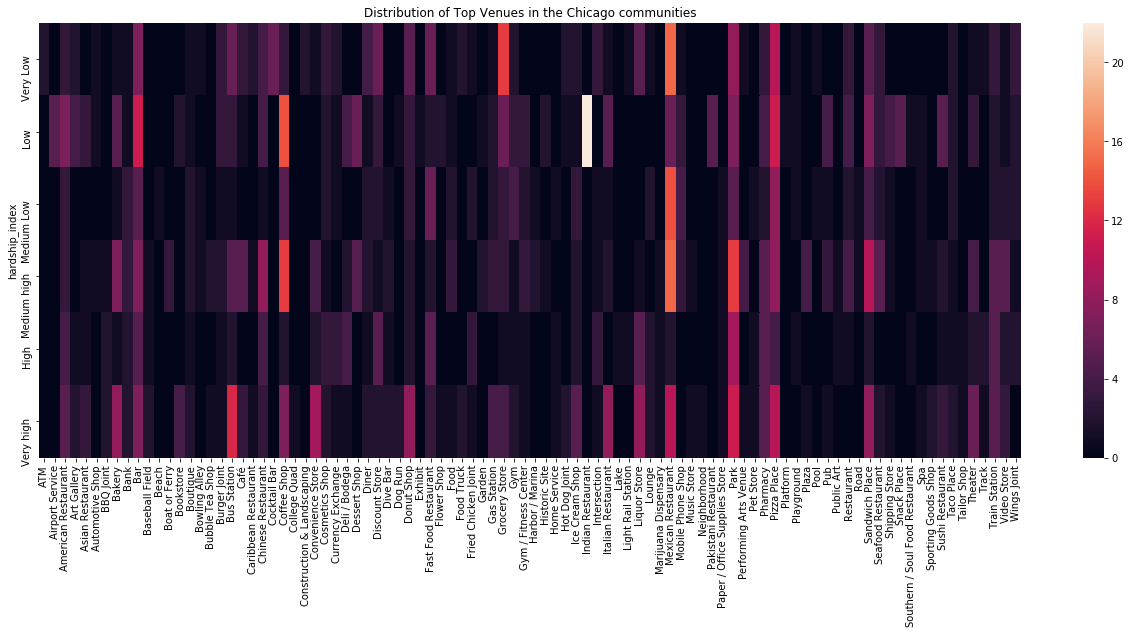

In [23]:
# Display the information in a heatmap
plt.figure(figsize=(22,8))
sns.heatmap(top_venues_grouped[top_venues_grouped.columns[:-1]])
plt.title('Distribution of Top Venues in the Chicago communities')
plt.show()

## At first glance it seems that there's not a good pattern to recognize differences in the venues between communities having different hardship index

### Let's scale the data to see if a pattern can be recognized

In [24]:
# Define the data to be scaled
X = top_venues_grouped[top_venues_grouped.columns[:-1]]


# Set up the scaler
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
# Transform the data
X = scaler.fit_transform(X)

# Create a new Dataframe with the scaled data
scaled_top_venues = pd.DataFrame(X, index=top_venues_grouped.index,columns=top_venues_grouped.columns[:-1])

### Let's visualize the new data

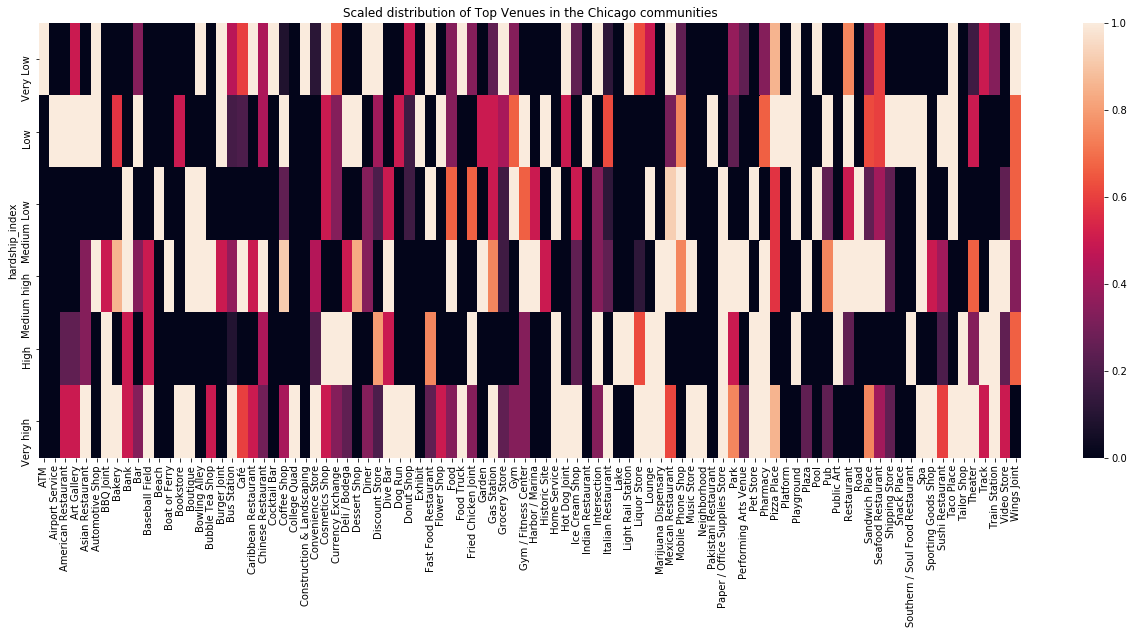

In [36]:
plt.figure(figsize=(22,8))
sns.heatmap(scaled_top_venues)
plt.title('Scaled distribution of Top Venues in the Chicago communities')
plt.savefig('img/heatmap.jpg')

### Although some differences are visible now, we cannot asure there are significative differences in the data

Testing the data with a chi-squared test will tell us if the distribution of the venues is completely random or not

In [26]:
#Let's get the p-values
chisq = chisquare(X, axis=1)
print(f'The p-values for each of the hardship indexes are: {chisq[1]}')

The p-values for each of the hardship indexes are: [0.99999328 0.99999907 0.99994058 0.99999988 0.99979102 1.        ]


### We can see that the p-values are very high, telling us the distribution of the venues is random

#### Despite these results let's try to train a model to classify the communities from their venue composition

In [27]:
# Let's create our training and test samples


X = top_venues[top_venues.columns[0:-1]]
y = community_venues_sorted['hardship_index']
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

## K Nearest Neighbors Classifier

In [28]:
# Define the parameters to be used with the grid search

params = {'n_neighbors': range(1,25)}

# Instantiate a grid and train it
grid_knn = GridSearchCV(KNeighborsClassifier(),param_grid=params, cv=5, scoring = 'jaccard_weighted')
grid_knn.fit(X_train,y_train)

# Get the best parameters
print(f'The best parameters for the model are: {grid_knn.best_params_}')


The best parameters for the model are: {'n_neighbors': 20}


/home/emmanuel/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [29]:
# Get predictions
predict = grid_knn.predict(X_test)

# Evaluate the model's performance
print(classification_report(y_test, predict))

              precision    recall  f1-score   support

        High       0.00      0.00      0.00         6
         Low       0.00      0.00      0.00         5
  Medium Low       0.33      0.50      0.40         4
 Medium high       0.00      0.00      0.00         2
    Very Low       0.10      0.33      0.15         3
   Very high       0.00      0.00      0.00         6

    accuracy                           0.12        26
   macro avg       0.07      0.14      0.09        26
weighted avg       0.06      0.12      0.08        26



/home/emmanuel/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


#### The warning is telling us there are no examples of certain labels within the test data, so even it's not recommended let's predict the whole data

In [30]:
# Get predictions
predict = grid_knn.predict(X)

# Evaluate the model's performance
print(classification_report(y, predict))

              precision    recall  f1-score   support

        High       0.00      0.00      0.00        12
         Low       0.67      0.17      0.27        12
  Medium Low       0.19      0.42      0.26        12
 Medium high       0.22      0.15      0.18        13
    Very Low       0.26      0.50      0.34        14
   Very high       0.33      0.07      0.12        14

    accuracy                           0.22        77
   macro avg       0.28      0.22      0.19        77
weighted avg       0.28      0.22      0.20        77



## The model performs poorly getting only a f1-score of 0.20

#### Let's try again but with a Random Forest Classifier (an ensemble of Decision Tree Classifiers)

## Random Forest Classifier

In [31]:
# Define the parameters to be used with the grid search

params = {'n_estimators': range(10,25), 'criterion':['gini', 'entropy']}

# Instantiate a grid and train it
grid_rf = GridSearchCV(RandomForestClassifier(),param_grid=params, cv=5, scoring = 'jaccard_weighted')
grid_rf.fit(X_train,y_train)

# Get the best parameters
print(f'The best parameters for the model are: {grid_rf.best_params_}')


The best parameters for the model are: {'criterion': 'gini', 'n_estimators': 23}


/home/emmanuel/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [32]:
# Get predictions
predict = grid_knn.predict(X_test)

# Evaluate the model's performance
print(classification_report(y_test, predict))

# Get predictions with the whole set
predict = grid_knn.predict(X)

# Evaluate the model's performance
print(classification_report(y, predict))

              precision    recall  f1-score   support

        High       0.00      0.00      0.00         6
         Low       0.00      0.00      0.00         5
  Medium Low       0.33      0.50      0.40         4
 Medium high       0.00      0.00      0.00         2
    Very Low       0.10      0.33      0.15         3
   Very high       0.00      0.00      0.00         6

    accuracy                           0.12        26
   macro avg       0.07      0.14      0.09        26
weighted avg       0.06      0.12      0.08        26

              precision    recall  f1-score   support

        High       0.00      0.00      0.00        12
         Low       0.67      0.17      0.27        12
  Medium Low       0.19      0.42      0.26        12
 Medium high       0.22      0.15      0.18        13
    Very Low       0.26      0.50      0.34        14
   Very high       0.33      0.07      0.12        14

    accuracy                           0.22        77
   macro avg       0.28

/home/emmanuel/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## It seems that the best both models can achieve is a f1-score of 0.20

# Conclusions

The Chicago communities are pretty similar in types of venues distribution so they are not a good predictor of the Hardship Index. Unfortunately this mean that (at least with the data presented here) there are no clear indications of which kind of venues can improve a community socioeconomic conditions, in the data obtained through the analysis we can verify that some buildings and spaces that we might think can improve community life such as parks are more represented in  communities with high Hardship Index, indicating that the problem may lay elsewhere.

### Extra:
Mexican Restaurants are the top venue at low Hardship Index locations, so if you are loooking for some comfort food you can go to your local mexican deliciousness parlor

If you're from Chicago I leave you here a map of mexican restaurants

In [33]:
mex_rest = chicago_venues[chicago_venues['Venue Category'] == 'Mexican Restaurant'][['Venue','Venue Latitude', 'Venue Longitude']]

In [34]:
mexican_restaurants = folium.Map(location=[latitude, longitude], zoom_start=10)

folium.Choropleth(geo_data = geojson,
                name = 'choropleth',
                data = chicago_h_i,
                columns= ['COMMUNITY AREA NAME','HARDSHIP INDEX'],
                key_on= 'feature.properties.community',
                fill_color='YlOrRd',
                fill_opacity=0.5,
                line_opacity=0.2,
                legend_name='Hardship Index').add_to(mexican_restaurants)


for lat, lng, label in zip(mex_rest['Venue Latitude'],mex_rest['Venue Longitude'], mex_rest['Venue']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=4,
        popup=label,
        color='green',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.6,
        parse_html=False).add_to(mexican_restaurants)
    
mexican_restaurants